# ECE 57000 Assignment 4 Exercise

Your Name:

## Exercise 0: Train your model on GPU (0 points)

For some tasks in this assignment, it can take a long time if you run it on CPU. For example, based on our test on Exercise 3 Task 4, it will take roughly 2 hours to train the full model for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.



In [1]:
import torch
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [2]:
import torch.nn as nn
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

device = torch.device('cuda')
# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device
rand_tensor=rand_tensor.to(device)
simple_model.to(device)

# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


## Exercise 1: Why use a CNN rather than only fully connected layers? (30 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Following the structure used in the instructions, you should create

*   One network named **OurFC** which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network 
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named **OurCNN** which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions
* You are **required** to print out the loss in the training and loss+accuracy in the test as in the instructions.

In [3]:
# ----------- <Your code> ---------------
import torch.nn.functional as F
class OurFC(nn.Module):

  def __init__(self):
    super(OurFC, self).__init__()

    self.fc1 = nn.Linear(784, 128)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.fc1(x.view(-1,784))
    x = self.relu(x)
    x = self.fc2(x)
    return x

class OurCNN(nn.Module):

  def __init__(self):
    super(OurCNN, self).__init__()

    self.CNN = nn.Conv2d(1, 2, kernel_size=3, padding="same") # 2x28x28
    self.pool = nn.MaxPool2d(2) # 2x14x14
    self.relu = nn.ReLU() 
    self.fc = nn.Linear(392, 10)

  def forward(self, x):
    x = self.CNN(x)
    x = self.pool(x)
    x = x.view(-1, 392)
    x = self.relu(x)
    x = self.fc(x)
    return x

def train(classifier, epoch):

  classifier.train() # we need to set the mode for our model

  for batch_idx, (images, targets) in enumerate(train_loader):

    optimizer.zero_grad()
    output = classifier(images.to(device))
    loss = loss_fn(output, targets.to(device)) # Here is a typical loss function (negative log likelihood)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 10 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')


def test(classifier, epoch):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      output = classifier(images.to(device))
      test_loss += loss_fn(output, targets.to(device)).sum().item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.to(device).data.view_as(pred)).sum() # sum up the corrected samples
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

In [ ]:
import torchvision

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST('/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('/data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 200, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

import torch.optim as optim

classifier = OurFC().to(device)
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.8)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

for epoch in range(1, max_epoch+1):
  train(classifier, epoch)
  test(classifier, epoch)

classifier2 = OurCNN().to(device)
optimizer = optim.SGD(classifier2.parameters(), lr=0.001, momentum=0.8)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

for epoch in range(1, max_epoch+1):
  train(classifier2, epoch)
  test(classifier2, epoch)

Epoch 1: [0/60000] Loss: 2.34684419631958
Epoch 1: [20000/60000] Loss: 1.5853430032730103
Epoch 1: [40000/60000] Loss: 1.0943905115127563
Test result on epoch 1: Avg loss is 0.0007507535994052887, Accuracy: 84.36000061035156%
Epoch 2: [0/60000] Loss: 0.7435910701751709
Epoch 2: [20000/60000] Loss: 0.5644620656967163
Epoch 2: [40000/60000] Loss: 0.5621421337127686
Test result on epoch 2: Avg loss is 0.0004892908960580826, Accuracy: 88.05999755859375%
Epoch 3: [0/60000] Loss: 0.4432069659233093
Epoch 3: [20000/60000] Loss: 0.5284782648086548
Epoch 3: [40000/60000] Loss: 0.575587272644043
Test result on epoch 3: Avg loss is 0.00040650634169578554, Accuracy: 89.37999725341797%
Epoch 1: [0/60000] Loss: 2.443662643432617
Epoch 1: [20000/60000] Loss: 1.3923701047897339
Epoch 1: [40000/60000] Loss: 0.5982366800308228
Test result on epoch 1: Avg loss is 0.00046525432169437406, Accuracy: 87.25%
Epoch 2: [0/60000] Loss: 0.5371224880218506
Epoch 2: [20000/60000] Loss: 0.4270678758621216
Epoch 2: [

### Task 2: Compare the number of parameters that are used in both your neural networks by printing out the total number of parameters for both of your networks.

**Note:** You need to clearly show which number corresponds to which network.

In [ ]:
# ----------- <Your code> ---------------
print(f"The number of parameters in fully connected neural network is {sum(p.numel() for p in classifier.parameters() if p.requires_grad)}")
print(f"The number of parameters in convalutional neural network is {sum(p.numel() for p in classifier2.parameters() if p.requires_grad)}")

The number of parameters in fully connected neural network is 101770
The number of parameters in convalutional neural network is 3950


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders and plot images
Set up a `train_loader` and `test_loader` for the CIFAR-10 data, and plot a figure:

*   3 x 3 subplot
*   each subplot is a randomly chosen image from the test dataset
*   label each image with its label

The corresponding names of the classes is given as 
`classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')`

Note: In your transforms, the normalizing constant is given as `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`

Files already downloaded and verified
Files already downloaded and verified


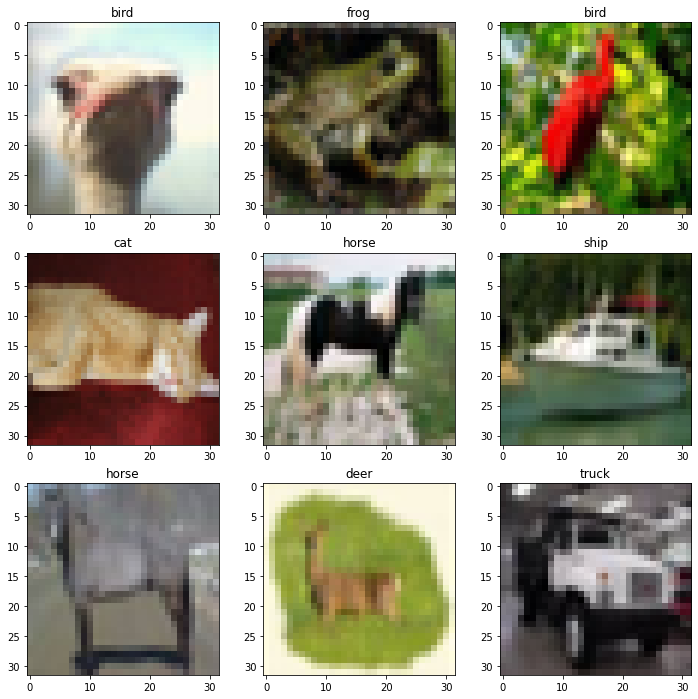

In [ ]:
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('/data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 200, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt

_, (images, targets) = next(enumerate(test_loader))
fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,12)
for i in range(3):
  for j in range(3):
    img = images[i*3+j] / 2 + 0.5 
    ax[i,j].imshow(img.permute(1, 2, 0))
    ax[i,j].set_title(f'{classes[targets[i*3+j]]}')

fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards:


*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [ ]:
# ----------- <Your code> ---------------
# You should have your test accuracy printed in the output box
import torch.nn as nn
import torch.nn.functional as F


class CNNcifar(nn.Module):
    def __init__(self):
        super(CNNcifar,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = CNNcifar().to(device)

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 50

for epoch in range(1, max_epoch+1):
  train(net, epoch)
  test(net, epoch)

Epoch 1: [0/50000] Loss: 2.298560857772827
Epoch 1: [20000/50000] Loss: 2.3040571212768555
Epoch 1: [40000/50000] Loss: 2.298715591430664
Test result on epoch 1: Avg loss is 0.0023024892807006836, Accuracy: 10.460000038146973%
Epoch 2: [0/50000] Loss: 2.3059513568878174
Epoch 2: [20000/50000] Loss: 2.3030688762664795
Epoch 2: [40000/50000] Loss: 2.2980804443359375
Test result on epoch 2: Avg loss is 0.0023007736921310425, Accuracy: 11.619999885559082%
Epoch 3: [0/50000] Loss: 2.3014402389526367
Epoch 3: [20000/50000] Loss: 2.3000118732452393
Epoch 3: [40000/50000] Loss: 2.2997007369995117
Test result on epoch 3: Avg loss is 0.0022984649658203127, Accuracy: 11.34999942779541%
Epoch 4: [0/50000] Loss: 2.2979304790496826
Epoch 4: [20000/50000] Loss: 2.2972524166107178
Epoch 4: [40000/50000] Loss: 2.2943031787872314
Test result on epoch 4: Avg loss is 0.0022939460515975954, Accuracy: 14.75%
Epoch 5: [0/50000] Loss: 2.2896595001220703
Epoch 5: [20000/50000] Loss: 2.28877329826355
Epoch 5: [

### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label



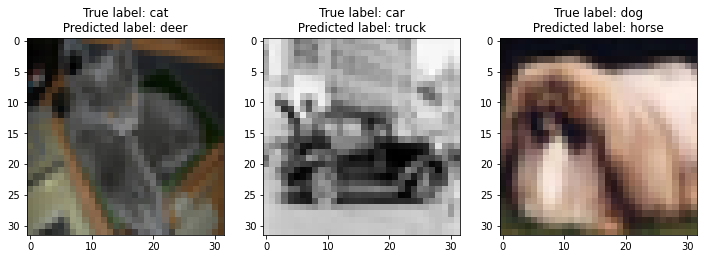

In [ ]:
# ----------- <Your code> ---------------
_, (images, targets) = next(enumerate(test_loader))
output = net(images.to(device))

pred = output.data.max(1, keepdim=True)[1].view((-1))
index = pred.data!=targets.to(device).data
images_wrong  = images[index]
targets_wrong = targets[index]
pred_wrong  = pred[index]

fig, ax = plt.subplots(1,3)
fig.set_size_inches(12,4)
for i in range(3):
  img = images[i] / 2 + 0.5 
  ax[i].imshow(img.permute(1, 2, 0))
  ax[i].set_title(f'True label: {classes[targets_wrong[i]]}\n Predicted label: {classes[pred_wrong[i]]} ')

fig.show()

Questions (0 points): Are the mis-classified images also misleading to human eyes?

## Exercise 3: Transfer Learning (30 points)

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [4]:
# ----------- <Your code> ---------------
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
# num_ftrs = resnet18.fc.in_features
# resnet18.fc = nn.Linear(num_ftrs, 2)
resnet18 = resnet18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Task2: Create data loaders for CIFAR-10

Then you need to create a dataloader of CIFAR-10. Note that the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width. See [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize).
You will probably want to add this transform appropriately to the `transform` you created in a previous task.


In [5]:
# ----------- <Your code> ---------------\
from torchvision import transforms, datasets
data_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = datasets.CIFAR10('/data', train=True, download=True, transform=data_transforms)
test_dataset = datasets.CIFAR10('/data', train=False, download=True, transform=data_transforms)

batch_size_train, batch_size_test = 200, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [ ]:
# ----------- <Your code> ---------------
loss_fn = nn.CrossEntropyLoss()

test_losses = []
test_counter = []

resnet18.eval() # we need to set the mode for our model

test_loss = 0
correct = 0

with torch.no_grad():
  for images, targets in test_loader:
    output = resnet18(images.to(device))
    pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
    correct += pred.eq(targets.to(device).data.view_as(pred)).sum() # sum up the corrected samples
    # print(targets.data)
test_counter.append(len(train_loader.dataset))

print(f'Accuracy: {100.*correct/len(test_loader.dataset)}%')

Accuracy: 0.0%


### Task 4: Update model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data. 

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You should print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [ ]:
# ----------- <Your code> ---------------

for param in resnet18.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

resnet18 = resnet18.to(device)

import torch.optim as optim
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 4

for epoch in range(1, max_epoch+1):
  train(resnet18, epoch)
  test(resnet18, epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: [0/50000] Loss: 2.6739706993103027
Epoch 1: [20000/50000] Loss: 1.2383122444152832
Epoch 1: [40000/50000] Loss: 1.012704849243164
Test result on epoch 1: Avg loss is 0.0009197867333889007, Accuracy: 73.18000030517578%
Epoch 2: [0/50000] Loss: 0.952283501625061
Epoch 2: [20000/50000] Loss: 0.8607823252677917
Epoch 2: [40000/50000] Loss: 0.7387840151786804
Test result on epoch 2: Avg loss is 0.0007618453919887543, Accuracy: 76.2699966430664%
Epoch 3: [0/50000] Loss: 0.8258564472198486
Epoch 3: [20000/50000] Loss: 0.6808072924613953
Epoch 3: [40000/50000] Loss: 0.6592823266983032
Test result on epoch 3: Avg loss is 0.000703230893611908, Accuracy: 78.40999603271484%
Epoch 4: [0/50000] Loss: 0.7451006174087524
Epoch 4: [20000/50000] Loss: 0.7328245043754578
Epoch 4: [40000/50000] Loss: 0.7312229671362798
Test result on epoch 4: Avg loss is 0.000695399180501254, Accuracy: 80.35412512354512%
